**Visual Graph Learning with GCN for Financial Forecasting: CNN-Based
OHLC Image Embeddings and Market Topology**

# **CODE 3 : Similarity_MST**

# 🛠️ Setup

In [ ]:
# @title Import packages

import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle as pkl
from PIL import Image
import matplotlib.pyplot as plt
import networkx as nx

from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import warnings
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

warnings.filterwarnings("ignore", category=DeprecationWarning)
np.random.seed(42)

In [ ]:
# @title Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CNN 模型定義

In [ ]:
# @title 20-day CNN Architecture
# (BasicBlock, Bottleneck, CNN20d)

class BasicBlock(nn.Module):
    """
    ResNet 基礎殘差區塊 (對應圖中的 5x3 -> 5x3)
    """
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()

        # --- 主路徑 (Main Path) ---
        self.main_path = nn.Sequential(
            # 1. 5x3 Conv
            nn.BatchNorm2d(in_channels),
            nn.GELU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=(5, 3), stride=1, padding=(2, 1)),
            # 2. 5x3 Conv
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(5, 3), stride=1, padding=(2, 1)),

        )

        # --- 跳接 (Shortcut Path) ---
        self.shortcut = nn.Sequential() # 默認為 Identity

        # 如果輸入/輸出通道數不同 (例如 64 -> 128)，
        # 我們需要一個 1x1 卷積來匹配維度
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        main_out = self.main_path(x)
        shortcut_out = self.shortcut(x)
        out = main_out + shortcut_out # 不加 final activation
        return out

class BottleneckBlock(nn.Module):
    """
    ResNet 瓶頸殘差區塊 (對應圖中的 1x1 -> 5x3 -> 1x1)
    """
    def __init__(self, in_channels, out_channels, squeeze_channels):
        """
        Args:
            in_channels (int): 輸入通道數
            out_channels (int): 輸出通道數 (例如 512)
            squeeze_channels (int): 瓶頸壓縮後的通道數 (例如 128)
        """
        super(BottleneckBlock, self).__init__()

        # --- 主路徑 (Main Path) ---
        self.main_path = nn.Sequential(
            # 1. 1x1 Conv (壓縮)
            nn.BatchNorm2d(in_channels),
            nn.GELU(),
            nn.Conv2d(in_channels, squeeze_channels, kernel_size=1, stride=1, padding=0),


            # 2. 5x3 Conv (您的核心卷積)
            nn.BatchNorm2d(squeeze_channels),
            nn.GELU(),
            nn.Conv2d(squeeze_channels, squeeze_channels, kernel_size=(5, 3), stride=1, padding=(2, 1)),


            # 3. 1x1 Conv (擴展)
            nn.BatchNorm2d(squeeze_channels),
            nn.GELU(),
            nn.Conv2d(squeeze_channels, out_channels, kernel_size=1, stride=1, padding=0),
        )

        # --- 跳接 (Shortcut Path) ---
        self.shortcut = nn.Sequential() # 默認為 Identity

        # 如果輸入/輸出通道數不同 (例如 256 -> 512)，
        # 或這是第一個區塊，我們需要一個 1x1 卷積來匹配維度
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        main_out = self.main_path(x)
        shortcut_out = self.shortcut(x)
        out = main_out + shortcut_out # 不加 final activation
        return out

class CNN20d(nn.Module):

    def init_weights(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)

    def _make_layer(self, block_type, in_channels, out_channels, num_blocks, squeeze_channels=None):
        """
        建立一個包含 N 個殘差區塊的層 (Stage)
        """
        layers = []

        # 第一個區塊：處理輸入/輸出通道數不同的情況
        if block_type == BottleneckBlock:
            layers.append(block_type(in_channels, out_channels, squeeze_channels))
        else: # BasicBlock
            layers.append(block_type(in_channels, out_channels))

        # 剩餘的 (num_blocks - 1) 個區塊
        for _ in range(1, num_blocks):
            if block_type == BottleneckBlock:
                # 後續區塊的 in_channels 等於 out_channels
                layers.append(block_type(out_channels, out_channels, squeeze_channels))
            else: # BasicBlock
                layers.append(block_type(out_channels, out_channels))

        return nn.Sequential(*layers)

    def __init__(self, num_classes=2, regression_outputs=1):
        super(CNN20d, self).__init__()

        # 1. Stem (莖幹層) - 根據您的 H/W 調整
        self.conv1 = nn.Sequential(
            # 使用 5x3 卷積核 (kernel_size=(5, 3)) 更適合您的非方形輸入
            # padding=(2, 1) 可以在 stride=1 時保持 H 和 W 尺寸不變
            nn.BatchNorm2d(1),
            nn.GELU(),
            nn.Conv2d(1, 64, kernel_size=(5, 3), stride=1, padding=(2, 1))
        )

        self.pool1 = nn.MaxPool2d((2, 1)) # 第一個 MaxPool

        # 2. Stage 1 - 對應圖中 x2 (BasicBlock, 64)
        self.stage1 = self._make_layer(BasicBlock, 64, 64, num_blocks=2)

        # 3. Stage 2 - 對應圖中 x2 (BasicBlock, 128)
        self.stage2 = self._make_layer(BasicBlock, 64, 128, num_blocks=2)

        # 4. Stage 3 - 對應圖中 x2 (BasicBlock, 256)
        self.stage3 = self._make_layer(BottleneckBlock, 128, 256, num_blocks=2, squeeze_channels=64)
        self.pool2 = nn.MaxPool2d((2, 1)) # 第二個 MaxPool

        # 5. Stage 4 - 對應圖中 x2 (Bottleneck, 128 -> 512)
        # 瓶頸壓縮通道數為 128，輸出通道數為 512
        self.stage4 = self._make_layer(BottleneckBlock, 256, 512, num_blocks=2, squeeze_channels=128)


        # 6. Final Pooling (全局平均池化)
        # 這會將 (Batch, 512, H, W) -> (Batch, 512, 1, 1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # 7. Dropout 和全連接層
        self.DropOut = nn.Dropout(p=0.5)

        # flattened_size 現在固定為最後的通道數 512
        self.classification_fc = nn.Linear(512, num_classes)
        self.classification_activation = nn.Softmax(dim=1)

        # self.regression_fc = nn.Linear(512, regression_outputs)
        # self.regression_activation = nn.Identity()

        self.apply(self.init_weights)

    def forward(self, x, task_type='classification', embedding=None, return_params=False):
        # 確保輸入是 (Batch, Channels, H, W)
        # 原始碼是 (Batch, H, W)，所以 unsqueeze(1) 變成 (Batch, 1, H, W)
        x = x.unsqueeze(1).to(torch.float32)

        outputs = {}

        # 按照架構圖順序執行
        x = self.conv1(x)
        x = self.pool1(x)
        outputs['conv1'] = x

        x = self.stage1(x)
        outputs['stage1'] = x

        x = self.stage2(x)
        outputs['stage2'] = x

        x = self.stage3(x)
        x = self.pool2(x)
        outputs['stage3'] = x

        x = self.stage4(x)
        outputs['stage4'] = x

        x = self.avgpool(x)
        # x shape: (Batch, 512, 1, 1)

        # 展平 (Flatten)
        x = torch.flatten(x, 1) # (Batch, 512)

        x = self.DropOut(x)
        outputs['flatten'] = x

        if embedding in outputs:
            return outputs[embedding]

        # Task-specific output (這部分邏輯與您原碼相同)
        if task_type == 'classification':
            x = self.classification_fc(x)
            x = self.classification_activation(x)
        # elif task_type == 'regression':
        #     x = self.regression_fc(x)
        #     x = self.regression_activation(x)

        # (這部分邏輯與您原碼相同)
        if return_params and embedding:
            return {
                'params': dict(self.named_parameters()),
                'output': outputs[embedding]
            }

        return x

In [ ]:
# @title DepthwisePointwiseEncoder
# --- 新的 Encoder 架構 (Depthwise -> Pointwise -> FC) ---
class DepthwisePointwiseEncoder(nn.Module):
    def __init__(self, in_channels=256, dw_out_channels=256, pw_out_channels=16, gcn_in_dim=256, dropout=0.5):
        super(DepthwisePointwiseEncoder, self).__init__()

        # 1. Depthwise Convolution (空間特徵提取)
        self.depthwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=dw_out_channels,
            kernel_size=(4, 3),
            stride=(2, 3),
            padding=0,
            groups=in_channels # 關鍵: 每個 channel 獨立
        )
        self.bn1 = nn.BatchNorm2d(dw_out_channels)
        self.act1 = nn.GELU()

        # 2. Pointwise Convolution (Channel 壓縮)
        self.pointwise = nn.Conv2d(
            in_channels=dw_out_channels,
            out_channels=pw_out_channels,
            kernel_size=1,
            stride=1
        )
        self.bn2 = nn.BatchNorm2d(pw_out_channels)
        self.act2 = nn.GELU()

        # 3. Fully Connected (投影到 256 維)
        # 計算 Flatten 維度: 16 * 7 * 20 = 2240
        self.flatten_dim = pw_out_channels * 7 * 20
        self.dropout_layer = nn.Dropout(p=dropout)

        self.fc = nn.Linear(self.flatten_dim, gcn_in_dim)
        self.bn3 = nn.BatchNorm1d(gcn_in_dim)
        # self.act3 = nn.GELU()
        # 注意: 這裡我不放 Dropout，因為我們要存檔作為特徵，通常存檔時不希望有隨機性

    def forward(self, x):
        # x input: (Batch, 28, 256, 16, 60)
        b, n, c, h, w = x.shape

        # 合併 Batch 和 Node
        x = x.view(b * n, c, h, w)

        # Depthwise
        x = self.depthwise(x)      # (b*n, 256, 7, 20)
        x = self.bn1(x)
        x = self.act1(x)

        # Pointwise
        x = self.pointwise(x)      # (b*n, 16, 7, 20)
        x = self.bn2(x)
        x = self.act2(x)

        # Flatten
        x = x.view(b * n, -1)      # (b*n, 2240)
        x = self.dropout_layer(x)

        # FC -> GCN Input
        x = self.fc(x)             # (b*n, 256)
        x = self.bn3(x)
        # x = self.act3(x)  # 保留BN，可以拿掉GELU

        # 還原 (Batch, Node, Feature)
        x = x.view(b, n, -1)       # (b, 28, 256)
        return x

# 輔助函式

In [ ]:
# @title CNN embedding & Network
# (CNN Embedding & Graph)

# --- CNN embedding 抽取函數 ---
def CNN_conv(temp,model,embedding_layer = 'stage3'):
    device = torch.device('cuda')
    embedding = []
    with torch.no_grad():
        for idx, image in enumerate(temp['image']):
            image = torch.tensor(image.copy(), dtype=torch.float32)
            image = image.unsqueeze(0).to(device)
            output = model(image,embedding = embedding_layer).cpu().detach().numpy()
            embedding.append(output)
    temp[embedding_layer] = embedding
    return temp

def calculate_similarity_per_channel(temp, embedding_layer='stage3'):
    """
    embedding_layer: name of embedding column
    method: 'cosine'
    """
    # 1. 提取 Embeddings
    embeddings = np.array([x[0] for x in temp[embedding_layer]])
    # embeddings shape: (N_stocks, Channels, H, W)

    n_samples = len(embeddings)
    n_channels = embeddings.shape[1]
    channel_similarities = []

    # --- Debug: 檢查是否有一開始就是全 0 的特徵 ---
    # 如果某個股票的 Embedding 全是 0，那不管跟誰算相似度都是 0
    for i in range(n_samples):
        if np.all(embeddings[i] == 0):
            print(f"⚠️ 警告: Stock {i} 的原始 Embedding 全為 0！")

    # 2. 逐 Channel 計算相似度
    for c in range(n_channels):
        channel_features = embeddings[:, c, :, :]
        channel_features = channel_features.reshape(n_samples, -1)

        norms = np.linalg.norm(channel_features, axis=1, keepdims=True)
        # 避免除以 0
        norms = np.where(norms == 0, 1e-10, norms)

        features_normalized = channel_features / norms
        sim_matrix = np.dot(features_normalized, features_normalized.T)

        triu_indices = np.triu_indices(n_samples, k=1)
        channel_similarities.append(sim_matrix[triu_indices])

    channel_similarities = np.array(channel_similarities)

    # ==========================================
    # 🕵️‍♂️ 您的需求：確認這裡的非 0 狀況
    # ==========================================
    avg_similarities = np.mean(channel_similarities, axis=0)

    # 檢查有多少對股票的相似度是非常接近 0 的
    # 我們用一个极小值 1e-6 来判断是否"有效非0"
    non_zero_count = np.count_nonzero(avg_similarities > 1e-6)
    total_pairs = len(avg_similarities)

    # 3. 建立圖
    G = nx.Graph()
    G.add_nodes_from(temp['Stock'])

    # 🔴 修正：使用正確的樣本數 n_samples (28)，而不是字典長度 len(temp)
    triu_indices = np.triu_indices(n_samples, k=1)

    for idx, (i, j) in enumerate(zip(*triu_indices)):
        similarity = float(avg_similarities[idx])
        G.add_edge(temp['Stock'][i], temp['Stock'][j], weight=similarity)

    return G

def transform_weights(G):
    H = G.copy()
    for (u, v) in H.edges():
        cosine_weight = H[u][v]['weight']
        distance_weight = np.sqrt(2 * (1 - cosine_weight))
        H[u][v]['weight'] = distance_weight
    return H

def compute_mst(G):
    """
    使用 Scipy 計算 MST，並回傳帶有「相似度權重」的鄰接矩陣
    """
    nodes = list(G.nodes())
    n = len(nodes)
    node_map = {name: i for i, name in enumerate(nodes)}

    # 1. 建立相似度矩陣 (強制使用 float32 避免整數截斷問題)
    sim_matrix = np.zeros((n, n), dtype=np.float32)

    for u, v, data in G.edges(data=True):
        i, j = node_map[u], node_map[v]
        sim = data['weight']
        sim_matrix[i, j] = sim
        sim_matrix[j, i] = sim

    # --- Debug: 確認這裡的矩陣是有值的 ---
    # print(f"[Debug Internal] Sim Matrix Max: {sim_matrix.max():.4f}, Min (non-zero): {sim_matrix[sim_matrix>0].min():.4f}")

    # 2. 轉換為距離矩陣 (Dist = sqrt(2*(1-Sim)))
    # 這裡的數值大約會在 0.9 ~ 1.2 之間
    dist_matrix = np.sqrt(np.maximum(0, 2 * (1 - sim_matrix)))

    # 3. 計算 MST (使用 Scipy)
    # Scipy 會根據距離找最小生成樹
    dist_csr = csr_matrix(dist_matrix)
    mst_csr = minimum_spanning_tree(dist_csr)

    # 4. 根據 MST 結構填回相似度
    mst_rows, mst_cols = mst_csr.nonzero()

    # 建立最終矩陣 (同樣強制 float32)
    adj_matrix = np.zeros((n, n), dtype=np.float32)

    edge_count = 0
    epsilon = 1e-5

    for r, c in zip(mst_rows, mst_cols):
        # 根據 MST 找到的索引 (r, c)，去拿原始的相似度
        original_sim = sim_matrix[r, c]

        # 雙重保險：確保值不為 0
        final_weight = max(original_sim, epsilon)

        adj_matrix[r, c] = final_weight
        adj_matrix[c, r] = final_weight

        edge_count += 1

    # --- 最終檢查 ---
    # print(f"[Debug] Scipy MST 邊數: {edge_count} (預期: {n-1})")
    # print(f"[Debug] 最終矩陣非0元素: {np.count_nonzero(adj_matrix)} (預期: {(n-1)*2})")

    return adj_matrix

# 🛠️ 載入訓練好的CNN模型

In [ ]:
# --- 路徑設定 ---
# 基礎路徑
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project"

# 1. 輸入路徑 (Data_OHLC)
_subfolder_o = os.path.join(PROJECT_PATH, "Data_OHLC")

# --- 載入資料 ---
print(f"從 {_subfolder_o} 載入 test 資料...")
# GCN X
X_train_GCN = np.load(os.path.join(_subfolder_o, 'X_train_GCN.npy'))
X_val_GCN = np.load(os.path.join(_subfolder_o, 'X_val_GCN.npy'))
# GCN y
y_train_GCN = pd.read_csv(os.path.join(_subfolder_o, 'y_train_GCN.csv'))
y_val_GCN = pd.read_csv(os.path.join(_subfolder_o, 'y_val_GCN.csv'))

print(f"X_train_GCN shape: {X_train_GCN.shape}")
print(f"X_val_GCN shape: {X_val_GCN.shape}")
print(f"y_train_GCN shape: {y_train_GCN.shape}")
print(f"y_val_GCN shape: {y_val_GCN.shape}")

從 /content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project/Data_OHLC 載入 test 資料...
X_train_GCN shape: (1388, 28, 64, 60)
X_val_GCN shape: (595, 28, 64, 60)
y_train_GCN shape: (38864, 3)
y_val_GCN shape: (16660, 3)


In [ ]:
# --- 載入CNN模型 ---
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project"
CNN_output_dir = os.path.join(PROJECT_PATH, "CNN_model")

model_path = os.path.join(CNN_output_dir, "2_cnn20d_final_lr1e-4_y3.pth") #🛠️🛠️🛠️
device = torch.device('cuda')
model = CNN20d().to(device)

print(f"\n載入 CNN 權重從: {model_path}")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval() # *** 務必設為評估模式 ***
print("✅ CNN 模型載入完成並設為 eval() 模式。")


載入 CNN 權重從: /content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project/CNN_model/1_cnn20d_final_lr1e-4_y9.pth
✅ CNN 模型載入完成並設為 eval() 模式。


## 建立 N_t 與 A_t (train、val)

In [ ]:
# --- 建立並初始化 *新的* NodeCNNEncoder ---
device = torch.device('cuda')
DepthwisePointwiseEncoder = DepthwisePointwiseEncoder().to(device)
DepthwisePointwiseEncoder.eval() # 設為 eval 模式

# 初始化列表
N_t_train = []
A_t_train = []
N_t_val = []
A_t_val = []

# 取 28 檔股票名稱 (假設 X_train_GCN.shape[1] == 28)
stocks = [f"Stock_{i+1}" for i in range(X_train_GCN.shape[1])]

print("開始產生 Train 的 N_t, A_t (Full Dimension + Weighted)...")

with torch.no_grad():
  for t in tqdm(range(X_train_GCN.shape[0])):
      temp = {'Stock': stocks, 'image': X_train_GCN[t]}
      # 1. 取得 CNN embedding
      temp = CNN_conv(temp, model, embedding_layer='stage3')
      # 2. 建立相似度圖形
      G = calculate_similarity_per_channel(temp, embedding_layer='stage3')
      # 3. 計算 MST 鄰接矩陣
      mst_adj = compute_mst(G)
      A_t_train.append(mst_adj)

      # N_t 是 embedding
      # (28, 256, 16, 60) -> (Stocks, Channels, H, W)
      embeddings_large = np.array([x[0] for x in temp['stage3']])

      # 轉為 Tensor 並增加 Batch 維度 -> (1, 28, 256, 16, 60)
      emb_tensor = torch.from_numpy(embeddings_large).float().to(device).unsqueeze(0)

      # 使用 DepthwisePointwiseEncoder 進行壓縮
      #    (1, 28, 256, 16, 60) -> (1, 28, 256)
      encoded_features = DepthwisePointwiseEncoder(emb_tensor)

      # 8. !!! 移除 "batch" 維度 !!!
      #    (1, 28, 256) -> (28, 256)
      encoded_features_np = encoded_features.squeeze(0).cpu().numpy()

      # 直接存入，不做任何壓縮
      N_t_train.append(encoded_features_np)
      # -------------------

print("\n開始產生 Val 的 N_t, A_t ...")

with torch.no_grad():
  for t in tqdm(range(X_val_GCN.shape[0])):
      temp = {'Stock': stocks, 'image': X_val_GCN[t]}
      temp = CNN_conv(temp, model, embedding_layer='stage3')
      G = calculate_similarity_per_channel(temp, embedding_layer='stage3')
      mst_adj = compute_mst(G)
      A_t_val.append(mst_adj)

      # 提取、轉換、增加維度
      embeddings_large = np.array([x[0] for x in temp['stage3']])
      emb_tensor = torch.from_numpy(embeddings_large).float().to(device).unsqueeze(0)

      # 壓縮
      encoded_features = DepthwisePointwiseEncoder(emb_tensor)
      encoded_features_np = encoded_features.squeeze(0).cpu().numpy()
      N_t_val.append(encoded_features_np)


N_t_train = np.array(N_t_train)
A_t_train = np.array(A_t_train)
N_t_val = np.array(N_t_val)
A_t_val = np.array(A_t_val)

print("\n--- Shape 檢查 ---")
print("N_t_train:", N_t_train.shape) # 預期: (1388, 28, 256)
print("A_t_train:", A_t_train.shape) # 預期: (1388, 28, 28)
print("N_t_val:", N_t_val.shape)   # 預期: (595, 28, 256)
print("A_t_val:", A_t_val.shape)   # 預期: (595, 28, 28)


--- Shape 檢查 ---
N_t_train: (1388, 28, 256)
A_t_train: (1388, 28, 28)
N_t_val: (595, 28, 256)
A_t_val: (595, 28, 28)


In [ ]:
matrix = A_t_train[12]

# 計算非 0 元素個數
non_zero_count = np.count_nonzero(matrix)

print(f"矩陣形狀: {matrix.shape}")
print("非 0 元素個數: ",non_zero_count)

矩陣形狀: (28, 28)
非 0 元素個數:  54


## 存檔 MST_data

In [ ]:
# 基礎路徑
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project"

# --- 輸出路徑設定 ---
MST_output_dir = os.path.join(PROJECT_PATH, "MST_data")
os.makedirs(MST_output_dir, exist_ok=True)
print(f"資料將儲存至: {MST_output_dir}")

# --- 存檔 ---
np.save(os.path.join(MST_output_dir, 'N_t_train_y3.npy'), N_t_train)
np.save(os.path.join(MST_output_dir, 'A_t_train_y3.npy'), A_t_train)
np.save(os.path.join(MST_output_dir, 'N_t_val_y3.npy'), N_t_val)
np.save(os.path.join(MST_output_dir, 'A_t_val_y3.npy'), A_t_val)

print("✅ 已儲存 N_t_train_y3, A_t_train_y3, N_t_val_y3, A_t_val_y3")

資料將儲存至: /content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project/MST_data
✅ 已儲存 N_t_train_y3, A_t_train_y3, N_t_val_y3, A_t_val_y3


## 建立 N_t 與 A_t (test)

In [ ]:
# --- 路徑設定 ---
# 基礎路徑
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project"

# 1. 輸入路徑 (Data_OHLC)
_subfolder_o = os.path.join(PROJECT_PATH, "Data_OHLC")

# 2. CNN 模型路徑 (來自CNN_Draft的輸出CNN_model)
CNN_output_dir = os.path.join(PROJECT_PATH, "CNN_model")

# --- 載入資料 ---
print(f"從 {_subfolder_o} 載入 test 資料...")
# test X
X_test = np.load(os.path.join(_subfolder_o, 'X_test.npy'))

print(f"X_test shape: {X_test.shape}")

從 /content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project/Data_OHLC 載入 test 資料...
X_test shape: (5, 734, 28, 64, 60)


In [ ]:
# --- 載入CNN模型 ---
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project"
CNN_output_dir = os.path.join(PROJECT_PATH, "CNN_model")

model_path = os.path.join(CNN_output_dir, "2_cnn20d_final_lr1e-4_y3.pth") #🛠️🛠️🛠️
device = torch.device('cuda')
model = CNN20d().to(device)

print(f"\n載入 CNN 權重從: {model_path}")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval() # *** 務必設為評估模式 ***
print("✅ CNN 模型載入完成並設為 eval() 模式。")


載入 CNN 權重從: /content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project/CNN_model/2_cnn20d_final_lr1e-4_y3.pth
✅ CNN 模型載入完成並設為 eval() 模式。


In [ ]:
# --- 建立並初始化 *新的* NodeCNNEncoder ---
device = torch.device('cuda')
DepthwisePointwiseEncoder = DepthwisePointwiseEncoder().to(device)
DepthwisePointwiseEncoder.eval() # 設為 eval 模式

# 初始化列表
N_t_test = []
A_t_test = []

# 取 28 檔股票名稱 (假設 X_test.shape[1] == 28)
stocks = [f"Stock_{i+1}" for i in range(X_test.shape[2])]

print(f"X_test shape: {X_test.shape}")
num_test_sets = X_test.shape[0] # 5
num_days = X_test.shape[1] # 734

print("開始產生 Test 的 N_t, A_t (共 5 個測試集)...")

with torch.no_grad():
  for set_idx in range(num_test_sets):
    print(f"\n正在處理第 {set_idx + 1} / {num_test_sets} 個測試集...")

    current_set_Nt = []
    current_set_At = []


    for t in tqdm(range(num_days)):
        current_images = X_test[set_idx, t]

        temp = {'Stock': stocks, 'image': current_images}
        # 1. 取得 CNN embedding
        temp = CNN_conv(temp, model, embedding_layer='stage3')
        # 2. 建立相似度圖形
        G = calculate_similarity_per_channel(temp, embedding_layer='stage3')
        # 3. 計算 MST 鄰接矩陣
        mst_adj = compute_mst(G)
        A_t_test.append(mst_adj)

        # N_t 是 embedding
        # (28, 256, 16, 60) -> (Stocks, Channels, H, W)
        embeddings_large = np.array([x[0] for x in temp['stage3']])

        # 轉為 Tensor 並增加 Batch 維度 -> (1, 28, 256, 16, 60)
        emb_tensor = torch.from_numpy(embeddings_large).float().to(device).unsqueeze(0)

        # 使用 DepthwisePointwiseEncoder 進行壓縮
        #    (1, 28, 256, 16, 60) -> (1, 28, 256)
        encoded_features = DepthwisePointwiseEncoder(emb_tensor)

        # 8. !!! 移除 "batch" 維度 !!!
        #    (1, 28, 256) -> (28, 256)
        encoded_features_np = encoded_features.squeeze(0).cpu().numpy()

        # 直接存入，不做任何壓縮
        N_t_test.append(encoded_features_np)
        # -------------------

N_t_test = np.array(N_t_test)
A_t_test = np.array(A_t_test)

print("\n--- Shape 檢查 ---")
print("N_t_test:", N_t_test.shape) # 預期: (5, 734, 28, 256)
print("A_t_test:", A_t_test.shape) # 預期: (5, 734, 28, 28)

X_test shape: (5, 734, 28, 64, 60)
開始產生 Test 的 N_t, A_t (共 5 個測試集)...

正在處理第 1 / 5 個測試集...


100%|██████████| 734/734 [02:19<00:00,  5.25it/s]



正在處理第 2 / 5 個測試集...


100%|██████████| 734/734 [02:16<00:00,  5.37it/s]



正在處理第 3 / 5 個測試集...


100%|██████████| 734/734 [02:17<00:00,  5.35it/s]



正在處理第 4 / 5 個測試集...


100%|██████████| 734/734 [02:18<00:00,  5.28it/s]



正在處理第 5 / 5 個測試集...


100%|██████████| 734/734 [02:17<00:00,  5.34it/s]



--- Shape 檢查 ---
N_t_test: (3670, 28, 256)
A_t_test: (3670, 28, 28)


In [ ]:
N_t_test = N_t_test.reshape(5, 734, 28, 256)
A_t_test = A_t_test.reshape(5, 734, 28, 28)
print(f"轉換後形狀: N_t={N_t_test.shape}, A_t={A_t_test.shape}")

轉換後形狀: N_t=(5, 734, 28, 256), A_t=(5, 734, 28, 28)


In [ ]:
# 基礎路徑
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project"

# --- 輸出路徑設定 ---
MST_output_dir = os.path.join(PROJECT_PATH, "MST_data")
os.makedirs(MST_output_dir, exist_ok=True)
print(f"資料將儲存至: {MST_output_dir}")

# --- 存檔 ---
np.save(os.path.join(MST_output_dir, 'N_t_test_y3.npy'), N_t_test)
np.save(os.path.join(MST_output_dir, 'A_t_test_y3.npy'), A_t_test)

print("✅ 已儲存 N_t_test_y3, A_t_test_y3")

資料將儲存至: /content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project/MST_data
✅ 已儲存 N_t_test_y3, A_t_test_y3


# 視覺化對比

開始產生 2天 Train 的 N_t 


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


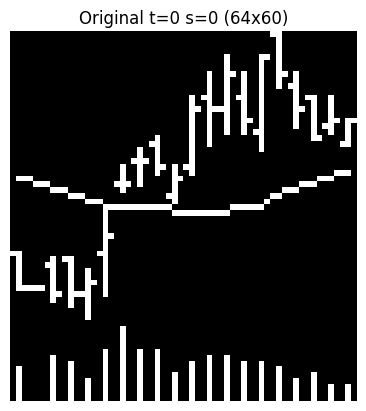

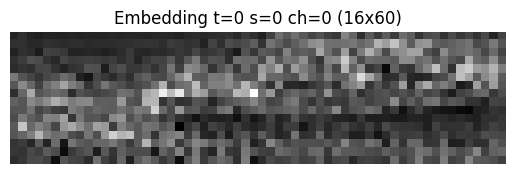

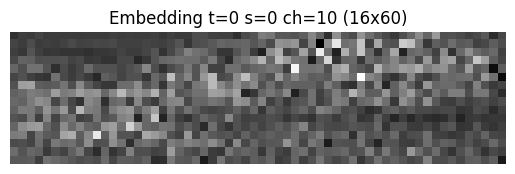

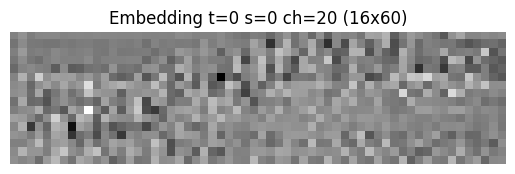

In [ ]:
# @title (Embedding vs Original)

# # (路徑設定與上一格相同)
# PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project"
# MST_output_dir = os.path.join(PROJECT_PATH, "MST_data")
# os.makedirs(MST_output_dir, exist_ok=True)

N_t_train_oneday = []

# 取 28 檔股票名稱
stocks = [f"Stock_{i+1}" for i in range(X_train_GCN.shape[1])]

print("開始產生 2天 Train 的 N_t ")

for t in tqdm(range(2)):
    temp = {'Stock': stocks, 'image': X_train_GCN[t]}
    temp = CNN_conv(temp, model, embedding_layer='stage3')
    # N_t 是 embedding
    embeddings = np.array([x[0] for x in temp['stage3']])  # (28, 256, 16, 60)
    N_t_train_oneday.append(embeddings)
N_t_train_oneday = np.array(N_t_train_oneday)

t, s = 0, 0  # 第一個時間點、第一支股票
channels_to_plot = [0, 10, 20]

# --- 顯示與存原始圖 ---
# 原始圖 (64x60)
orig_img = X_train_GCN[t, s]
orig_img_norm = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min() + 1e-10)

plt.imshow(orig_img_norm, cmap='gray')
plt.title(f"Original t={t} s={s} (64x60)")
plt.axis('off')
# orig_filename = os.path.join(MST_output_dir, f"t{t}_s{s}_original.png")
# plt.savefig(orig_filename, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()
# print(f"Saved original image: {orig_filename}")

# --- 顯示與存 embedding 圖 ---
# embedding 圖 (16x60)
for ch in channels_to_plot:
    emb_img = N_t_train_oneday[t, s, ch]  # shape (16, 60)
    emb_img_norm = (emb_img - emb_img.min()) / (emb_img.max() - emb_img.min() + 1e-10)

    plt.imshow(emb_img_norm, cmap='gray')
    plt.title(f"Embedding t={t} s={s} ch={ch} (16x60)")
    plt.axis('off')
    # emb_filename = os.path.join(MST_output_dir, f"t{t}_s{s}_ch{ch}.png")
    # plt.savefig(emb_filename, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()
    # print(f"Saved embedding image: {emb_filename}")

# 提取 $A_t$

In [ ]:
# @title 提取其中兩天的$A_t$ 28*28
import pandas as pd
import numpy as np
import os

# --- 1. 設定路徑 ---
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project"
_subfolder_o = os.path.join(PROJECT_PATH, "Data_OHLC")
MST_output_dir = os.path.join(PROJECT_PATH, "MST_data")

# 確保輸出資料夾存在
os.makedirs(MST_output_dir, exist_ok=True)

# --- 2. 載入 y 資料 (用於查找日期索引) ---
print("正在讀取 y 資料...")
y_train = pd.read_csv(os.path.join(_subfolder_o, 'y_train_GCN.csv'))
y_val = pd.read_csv(os.path.join(_subfolder_o, 'y_val_GCN.csv'))

# 取得日期欄位 (假設第一欄是日期)
date_col = y_train.columns[0]
print(f"使用日期欄位: {date_col}")

# 取得唯一日期序列
train_dates = y_train[date_col].unique()
val_dates = y_val[date_col].unique()

# --- 3. 設定目標日期與存檔名稱 ---
# 這裡使用剛才測試確認可用的日期格式
target_map = {
    "2004-09-22 16:00:00+00:00": "A_t_20040922.npy",
    "2005-11-08 16:00:00+00:00": "A_t_20051108.npy"
}

# 預先定義變數以避免重複載入大檔案
A_t_train_data = None
A_t_val_data = None

# --- 4. 執行搜尋與存檔 ---
for target_date, save_filename in target_map.items():
    matrix = None
    found = False

    # 檢查 Train
    if target_date in train_dates:
        idx = np.where(train_dates == target_date)[0][0]
        print(f"\n日期 {target_date} 位於 Train set, index {idx}")

        # Lazy loading: 只有在需要時才載入大檔案
        if A_t_train_data is None:
            print("  正在載入 A_t_train.npy ...")
            A_t_train_data = np.load(os.path.join(MST_output_dir, 'A_t_train.npy'))

        matrix = A_t_train_data[idx]
        found = True

    # 檢查 Val
    elif target_date in val_dates:
        idx = np.where(val_dates == target_date)[0][0]
        print(f"\n日期 {target_date} 位於 Val set, index {idx}")

        if A_t_val_data is None:
            print("  正在載入 A_t_val.npy ...")
            A_t_val_data = np.load(os.path.join(MST_output_dir, 'A_t_val.npy'))

        matrix = A_t_val_data[idx]
        found = True

    # 存檔
    if found and matrix is not None:
        save_path = os.path.join(MST_output_dir, save_filename)
        np.save(save_path, matrix)
        print(f"  ✅ 矩陣已儲存至: {save_path}")
        print(f"     (Shape: {matrix.shape}, Non-zeros: {np.count_nonzero(matrix)})")
    else:
        print(f"\n❌ 找不到日期: {target_date}")

print("\n所有檔案處理完成。")

正在讀取 y 資料...
使用日期欄位: TradeDate

日期 2004-09-22 16:00:00+00:00 位於 Train set, index 309
  正在載入 A_t_train.npy ...
  ✅ 矩陣已儲存至: /content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project/MST_data/A_t_20040922.npy
     (Shape: (28, 28), Non-zeros: 54)

日期 2005-11-08 16:00:00+00:00 位於 Train set, index 1105
  ✅ 矩陣已儲存至: /content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project/MST_data/A_t_20051108.npy
     (Shape: (28, 28), Non-zeros: 54)

所有檔案處理完成。


In [ ]:
# @title 提取其中兩天的sim 28*28
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os

# --- 1. 設定路徑 (請確認您的路徑正確) ---
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project"
_subfolder_o = os.path.join(PROJECT_PATH, "Data_OHLC")
CNN_output_dir = os.path.join(PROJECT_PATH, "CNN_model")
MST_output_dir = os.path.join(PROJECT_PATH, "MST_data")

# 確保輸出資料夾存在
os.makedirs(MST_output_dir, exist_ok=True)

# --- 2. 模型定義 (必須與訓練時一致才能載入權重) ---
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        self.main_path = nn.Sequential(
            nn.BatchNorm2d(in_channels), nn.GELU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=(5, 3), stride=1, padding=(2, 1)),
            nn.BatchNorm2d(out_channels), nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(5, 3), stride=1, padding=(2, 1))
        )
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        return self.main_path(x) + self.shortcut(x)

class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, squeeze_channels):
        super(BottleneckBlock, self).__init__()
        self.main_path = nn.Sequential(
            nn.BatchNorm2d(in_channels), nn.GELU(),
            nn.Conv2d(in_channels, squeeze_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(squeeze_channels), nn.GELU(),
            nn.Conv2d(squeeze_channels, squeeze_channels, kernel_size=(5, 3), stride=1, padding=(2, 1)),
            nn.BatchNorm2d(squeeze_channels), nn.GELU(),
            nn.Conv2d(squeeze_channels, out_channels, kernel_size=1, stride=1, padding=0)
        )
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        return self.main_path(x) + self.shortcut(x)

class CNN20d(nn.Module):
    def _make_layer(self, block_type, in_channels, out_channels, num_blocks, squeeze_channels=None):
        layers = []
        if block_type == BottleneckBlock:
            layers.append(block_type(in_channels, out_channels, squeeze_channels))
        else:
            layers.append(block_type(in_channels, out_channels))
        for _ in range(1, num_blocks):
            if block_type == BottleneckBlock:
                layers.append(block_type(out_channels, out_channels, squeeze_channels))
            else:
                layers.append(block_type(out_channels, out_channels))
        return nn.Sequential(*layers)

    def __init__(self, num_classes=2, regression_outputs=1):
        super(CNN20d, self).__init__()
        self.conv1 = nn.Sequential(
            nn.BatchNorm2d(1), nn.GELU(),
            nn.Conv2d(1, 64, kernel_size=(5, 3), stride=1, padding=(2, 1))
        )
        self.pool1 = nn.MaxPool2d((2, 1))
        self.stage1 = self._make_layer(BasicBlock, 64, 64, num_blocks=2)
        self.stage2 = self._make_layer(BasicBlock, 64, 128, num_blocks=2)
        self.stage3 = self._make_layer(BottleneckBlock, 128, 256, num_blocks=2, squeeze_channels=64)
        self.pool2 = nn.MaxPool2d((2, 1))
        self.stage4 = self._make_layer(BottleneckBlock, 256, 512, num_blocks=2, squeeze_channels=128)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.DropOut = nn.Dropout(p=0.5)
        self.classification_fc = nn.Linear(512, num_classes)
        self.classification_activation = nn.Softmax(dim=1)
        self.regression_fc = nn.Linear(512, regression_outputs)
        self.regression_activation = nn.Identity()

    def forward(self, x, task_type='classification', embedding=None, return_params=False):
        x = x.unsqueeze(1).to(torch.float32)
        outputs = {}
        x = self.conv1(x)
        x = self.pool1(x)
        outputs['conv1'] = x
        x = self.stage1(x)
        outputs['stage1'] = x
        x = self.stage2(x)
        outputs['stage2'] = x
        x = self.stage3(x)
        x = self.pool2(x)
        outputs['stage3'] = x
        x = self.stage4(x)
        outputs['stage4'] = x
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.DropOut(x)
        outputs['flatten'] = x
        if embedding in outputs:
            return outputs[embedding]
        if task_type == 'classification':
            x = self.classification_fc(x)
            x = self.classification_activation(x)
        elif task_type == 'regression':
            x = self.regression_fc(x)
            x = self.regression_activation(x)
        return x

# --- 3. 輔助函數 ---
def CNN_conv(images, model, embedding_layer='stage3'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    embedding = []
    with torch.no_grad():
        # images shape: (N, 64, 60)
        # 為了避免記憶體不足，逐筆處理
        for i in range(images.shape[0]):
            img = torch.tensor(images[i], dtype=torch.float32).unsqueeze(0).to(device)
            # output shape: (1, 256, 16, 60)
            output = model(img, embedding=embedding_layer).cpu().numpy()
            embedding.append(output)
    return np.array(embedding) # (28, 1, 256, 16, 60)

def get_similarity_matrix(embeddings):
    # embeddings input: (28, 1, 256, 16, 60)
    # 調整維度 -> (28, 256, 16, 60)
    embeddings = embeddings.squeeze(1)
    n_samples = embeddings.shape[0] # 28 stocks
    n_channels = embeddings.shape[1] # 256 channels

    channel_similarities = []

    # 逐 Channel 計算相似度
    for c in range(n_channels):
        # 取出第 c 個 channel 的特徵圖: (28, 16, 60)
        channel_feats = embeddings[:, c, :, :]
        # 展平成向量: (28, 16*60 = 960)
        channel_feats = channel_feats.reshape(n_samples, -1)

        # 正規化 (避免除以 0)
        norms = np.linalg.norm(channel_feats, axis=1, keepdims=True)
        norms = np.where(norms == 0, 1e-10, norms)
        feats_norm = channel_feats / norms

        # 計算 Cosine Similarity: (28, 960) @ (960, 28) -> (28, 28)
        sim = np.dot(feats_norm, feats_norm.T)
        channel_similarities.append(sim)

    # 將 256 個 Channel 的相似度取平均
    # shape: (256, 28, 28) -> (28, 28)
    avg_sim = np.mean(np.array(channel_similarities), axis=0)
    # === 關鍵修改：將對角線設為 0 ===
    np.fill_diagonal(avg_sim, 0)

    return avg_sim

# --- 4. 主程式執行 ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# A. 載入模型
# 請確認您的模型檔名是否正確
model_path = os.path.join(CNN_output_dir, "1_cnn20d_final_lr1e-4_y9.pth")
print(f"正在載入模型: {model_path}")

model = CNN20d().to(device)
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("模型載入成功！")
except FileNotFoundError:
    print(f"❌ 錯誤: 找不到模型檔案，請確認路徑: {model_path}")
    # 這裡如果失敗，後續會報錯，請修正路徑

# B. 載入 y 資料以搜尋索引
print("正在讀取 y 資料...")
y_train = pd.read_csv(os.path.join(_subfolder_o, 'y_train_GCN.csv'))
y_val = pd.read_csv(os.path.join(_subfolder_o, 'y_val_GCN.csv'))

date_col = y_train.columns[0]
train_dates = y_train[date_col].unique()
val_dates = y_val[date_col].unique()

# 目標日期
target_map = {
    "2004-09-22 16:00:00+00:00": "Sim_20040922.npy",
    "2005-11-08 16:00:00+00:00": "Sim_20051108.npy"
}

# C. 處理每個目標日期
for target_date, save_filename in target_map.items():
    print(f"\n>>> 處理日期: {target_date}")

    # 1. 找資料 (X)
    images = None

    if target_date in train_dates:
        idx = np.where(train_dates == target_date)[0][0]
        print(f"    位於 Train Set, Index {idx}")
        # Lazy Load X_train
        if 'X_train_GCN' not in locals():
            print("    載入 X_train_GCN.npy ...")
            X_train_GCN = np.load(os.path.join(_subfolder_o, 'X_train_GCN.npy'))
        images = X_train_GCN[idx] # (28, 64, 60)

    elif target_date in val_dates:
        idx = np.where(val_dates == target_date)[0][0]
        print(f"    位於 Val Set, Index {idx}")
        # Lazy Load X_val
        if 'X_val_GCN' not in locals():
            print("    載入 X_val_GCN.npy ...")
            X_val_GCN = np.load(os.path.join(_subfolder_o, 'X_val_GCN.npy'))
        images = X_val_GCN[idx]
    else:
        print("    ❌ 錯誤: 在資料集中找不到此日期")
        continue

    # 2. 提取特徵 (Embedding)
    print("    計算 Embedding ...")
    # images shape: (28, 64, 60)
    embeddings = CNN_conv(images, model)

    # 3. 計算相似度矩陣 (28x28)
    print("    計算 Similarity Matrix ...")
    sim_matrix = get_similarity_matrix(embeddings)

    # 4. 存檔
    save_path = os.path.join(MST_output_dir, save_filename)
    np.save(save_path, sim_matrix)

    print(f"    ✅ 已儲存: {save_filename}")
    print(f"       Shape: {sim_matrix.shape}")
    print(f"       Mean Sim: {sim_matrix.mean():.4f}, Max: {sim_matrix.max():.4f}, Min: {sim_matrix.min():.4f}")

print("\n所有作業完成！")

正在載入模型: /content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project/CNN_model/1_cnn20d_final_lr1e-4_y9.pth
模型載入成功！
正在讀取 y 資料...

>>> 處理日期: 2004-09-22 16:00:00+00:00
    位於 Train Set, Index 309
    計算 Embedding ...
    計算 Similarity Matrix ...
    ✅ 已儲存: Sim_20040922.npy
       Shape: (28, 28)
       Mean Sim: 0.3171, Max: 0.5616, Min: 0.0000

>>> 處理日期: 2005-11-08 16:00:00+00:00
    位於 Train Set, Index 1105
    計算 Embedding ...
    計算 Similarity Matrix ...
    ✅ 已儲存: Sim_20051108.npy
       Shape: (28, 28)
       Mean Sim: 0.3274, Max: 0.5915, Min: 0.0000

所有作業完成！


# ASPL

In [ ]:

import networkx as nx
import numpy as np
from tqdm import tqdm
import os

PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project"
MST_output_dir = os.path.join(PROJECT_PATH, "MST_data")

CNN_output_dir = os.path.join(PROJECT_PATH, "CNN_model")

print(f"從 {MST_output_dir} 載入 test 資料...")
# test X
A_t = np.load(os.path.join(MST_output_dir, 'A_t_train_y9.npy'))

print(f"A_t_train shape: {A_t.shape}")

aspl_list_weighted = []
aspl_list_Unweighted = []

print("正在計算 UN/Weighted ASPL (將相似度轉為距離)...")

for t in tqdm(range(A_t.shape[0])):
    # 1. 取出單張相似度矩陣
    sim_matrix = A_t[t]

    # 2. 建立圖形
    # NetworkX 會自動忽略 0 的值，只為非 0 的值建立邊
    # 此時邊的 weight 屬性是 "相似度"
    G = nx.from_numpy_array(sim_matrix)

    # --- 關鍵步驟：只針對存在的邊進行權重轉換 ---
    # 我們不對矩陣操作，而是直接修改圖上的邊
    for u, v, data in G.edges(data=True):
        similarity = data['weight']

        # 套用公式：Dist = sqrt(2 * (1 - Similarity))
        # 這裡要做個保護，避免浮點數誤差導致 1-similarity 變成負極小值
        val = max(0, 1 - similarity)
        distance = np.sqrt(2 * val)

        # 更新邊的權重為距離
        data['weight'] = distance

    # 3. 計算 ASPL
    # 設定 weight='weight'，代表計算路徑上"距離的總和"
    try:
        val_weighted = nx.average_shortest_path_length(G, weight='weight')
        val_Unweighted = nx.average_shortest_path_length(G, weight=None)
        aspl_list_weighted.append(val_weighted)
        aspl_list_Unweighted.append(val_Unweighted)
    except nx.NetworkXError:
        # 如果圖不連通 (例如某個時間點計算出的 MST 斷了)，會報錯
        # 在 MST 理論上不該發生，但以防萬一
        print(f"Warning: Graph at index {t} is not connected.")

# 4. 取平均
final_aspl_weighted = np.mean(aspl_list_weighted)
final_aspl_Unweighted = np.mean(aspl_list_Unweighted)


print("="*30)
print(f"計算完成！")
print(f"Weighted ASPL (Distance): {final_aspl_weighted:.4f}")
print(f"Unweighted ASPL (Hops): {final_aspl_Unweighted:.4f}")
print("="*30)